In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import warnings
from dotenv import load_dotenv
import os

warnings.filterwarnings('ignore')

load_dotenv()
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

In [24]:
# Function to Fetch Data from Alpha Vantage
def fetch_data(symbol, api_key):
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
    data = data['4. close']
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    return data

In [32]:
# Fetch data for GOOG and GOOGL
goog_data = fetch_data('GOOG', api_key)
googl_data = fetch_data('GOOGL', api_key)

# Check for missing values
goog_missing = goog_data.isnull().sum()
googl_missing = googl_data.isnull().sum()
combined_missing = pd.concat([goog_data, googl_data], axis=1).isnull().sum()

# Create a DataFrame for missing values information
missing_info = pd.DataFrame({
    'GOOG Missing Values': goog_missing,
    'GOOGL Missing Values': googl_missing,
    'Combined Data Missing Values': combined_missing
}).T

# Display the missing values information
missing_info

,4. close,4. close
GOOG Missing Values,0,0
GOOGL Missing Values,0,0
Combined Data Missing Values,2417,0


In [33]:
# Drop missing values in GOOG data
goog_data.dropna(inplace=True)

# Combine the data into a single DataFrame
data = pd.concat([goog_data, googl_data], axis=1)
data.columns = ['Close_GOOG', 'Close_GOOGL']

# Drop rows with missing values in combined data
data.dropna(inplace=True)

# Calculate the price ratio
data['Ratio'] = data['Close_GOOG'] / data['Close_GOOGL']

# Calculate the rolling mean and standard deviation of the ratio
window = 20
data['Rolling Mean'] = data['Ratio'].rolling(window=window).mean()
data['Rolling STD'] = data['Ratio'].rolling(window=window).std()

# Calculate the upper and lower bands
data['Upper Band'] = data['Rolling Mean'] + (data['Rolling STD'] * 2)
data['Lower Band'] = data['Rolling Mean'] - (data['Rolling STD'] * 2)

# Check for NaN values
nan_info = pd.DataFrame({
    'NaN values in Ratio': [data['Ratio'].isnull().sum()],
    'NaN values in Rolling Mean': [data['Rolling Mean'].isnull().sum()],
    'NaN values in Rolling STD': [data['Rolling STD'].isnull().sum()],
    'NaN values in Upper Band': [data['Upper Band'].isnull().sum()],
    'NaN values in Lower Band': [data['Lower Band'].isnull().sum()]
})

# Display NaN values information
nan_info

,NaN values in Ratio,NaN values in Rolling Mean,NaN values in Rolling STD,NaN values in Upper Band,NaN values in Lower Band
0,0,19,19,19,19


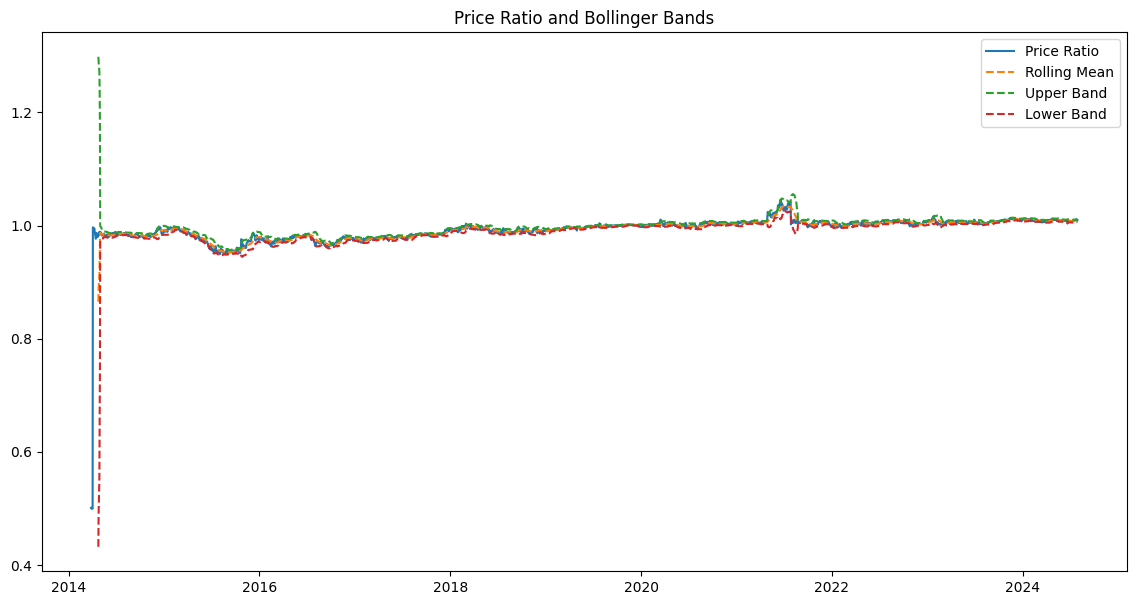

In [34]:
# Plot the ratio and the bands
plt.figure(figsize=(14, 7))
plt.plot(data['Ratio'], label='Price Ratio')
plt.plot(data['Rolling Mean'], label='Rolling Mean', linestyle='--')
plt.plot(data['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(data['Lower Band'], label='Lower Band', linestyle='--')
plt.legend()
plt.title('Price Ratio and Bollinger Bands')
plt.show()

In [35]:
# Generate Trading Signals
data['Signal'] = 0
data.loc[data['Ratio'] > data['Upper Band'], 'Signal'] = -1  # Short GOOG, Long GOOGL
data.loc[data['Ratio'] < data['Lower Band'], 'Signal'] = 1   # Long GOOG, Short GOOGL

# Display rows with non-NaN values for signals
non_nan_data = data.dropna(subset=['Upper Band', 'Lower Band'])
signal_info = non_nan_data[['Ratio', 'Upper Band', 'Lower Band', 'Signal']].head(30)

# Display the first few rows with signals as a table
signal_info

,Ratio,Upper Band,Lower Band,Signal
date,,,,
2014-04-24,0.982636,1.298270,0.432374,0
2014-04-25,0.986771,1.289791,0.489411,0
2014-04-28,0.988852,1.271457,0.556638,0
2014-04-29,0.983909,1.238531,0.637980,0
2014-04-30,0.984632,1.180815,0.744185,0
2014-05-01,0.986667,0.999476,0.974239,0
2014-05-02,0.988874,0.998206,0.974705,0
2014-05-05,0.985953,0.996778,0.975115,0
2014-05-06,0.985782,0.995339,0.975591,0


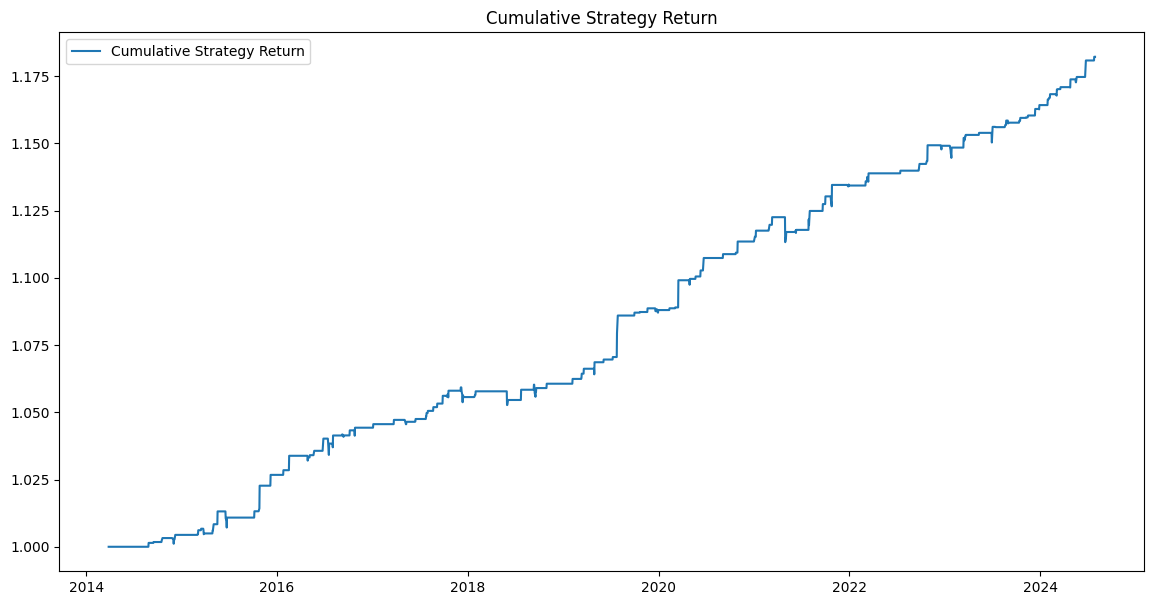

In [36]:
# Calculate Returns and Plot Cumulative Returns
# Calculate daily returns
data['GOOG_Return'] = data['Close_GOOG'].pct_change()
data['GOOGL_Return'] = data['Close_GOOGL'].pct_change()

# Calculate strategy returns
data['Strategy_Return'] = data['Signal'].shift(1) * (data['GOOG_Return'] - data['GOOGL_Return'])

# Plot cumulative returns
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()
plt.figure(figsize=(14, 7))
plt.plot(data['Cumulative_Strategy_Return'], label='Cumulative Strategy Return')
plt.legend()
plt.title('Cumulative Strategy Return')
plt.show()

## Reflection and Lessons Learned

Implemented a Dual Class Arbitrage trading strategy using the following tech stack:

### Tech Stack
- **Python**: The programming language used for implementation.
- **Pandas**: For data manipulation and analysis.
- **NumPy**: For numerical operations.
- **Matplotlib**: For data visualization.
- **Alpha Vantage API**: To fetch historical stock data.

### Steps Taken
1. **Environment Setup**: Set up the environment by importing necessary libraries and loading API keys securely using the `dotenv` package.
2. **Data Fetching**: Fetched historical daily close prices for GOOG and GOOGL using the Alpha Vantage API.
3. **Data Preparation**: Combined the data for both stocks and calculated the price ratio.
4. **Bollinger Bands Calculation**: Calculated the rolling mean and standard deviation of the price ratio and derived the upper and lower Bollinger Bands.
5. **Trading Signals Generation**: Generated trading signals based on the price ratio crossing the Bollinger Bands.
6. **Strategy Backtesting**: Calculated daily returns for both stocks, computed the strategy returns based on the generated signals, and plotted the cumulative returns.

### Key Learnings
- **Data Handling**: Efficient data handling and manipulation using Pandas is crucial for any quantitative finance project.
- **API Usage**: Leveraging APIs like Alpha Vantage for fetching financial data can simplify data acquisition processes.
- **Strategy Implementation**: Implementing trading strategies involves a clear understanding of financial metrics and signals.
- **Backtesting**: Backtesting helps evaluate the effectiveness of trading strategies over historical data, providing insights into potential performance.
